# **GPT Tokenizer:** `Byte-Pair Encoding (BPE)`
---

* Inspired by Andrej Karpathy's [Let's build the GPT Tokenizer](https://www.youtube.com/watch?v=zduSFxRajkE)
* Supplementary links
    - [tiktokenizer](https://tiktokenizer.vercel.app/)
    - [tiktoken](https://github.com/openai/tiktoken) from OpenAI
    - [sentencepiece](https://github.com/google/sentencepiece) from Google

# Table of Contents
------------------
- [0. Introduction: Tokenization](#0)
- [1. Tokenization Example in a web UI: `tiktokenizer`](#1)
- [2. **Strings** in Python: Unicode Code Points](#2)
- [3. Unicode Byte Encodings: `AsCII`, `UTF-8`, `UTF-16`, `UTF-32`](#3)
- [4. Daydreaming: Deleting Tokenization](#4)
- [5. **Byte Pair Encoding (BPE)**](#5)
    - [5.0. Implementation](#500)
    - [5.1. Counting Consecutive Pairs, Finding the Most Common Pair](#501)
    - [5.2. Merging the Most Common Pair](#502)
    - [5.3. Training the Tokenizer: **while loop, compression ratio**](#503)
- [6. Tokenizer/LLM Diagram](#6)
- [7. **Decoder:** Tokens to Strings](#7)
- [8. **Encoder:** Strings to Tokens](#8)
- [9. `Regex` Patterns: To Force Splits across Categories (`GPT` Series)](#9)
- [10. Introduction: `tiktoken` library, Differences btw GPT2 & GPT4 `Regex`](#10)
- [11. OpenAI GPT2 `encoder.py`: Walkthrough](#11)
- [12. Special Tokens in Language Models](#12)
- [13. **Exercise:** Write your own GPT4 Tokenizer; `minBPE`](#13)
- [14. Introduction: `sentencepiece` library](#14)
- [15. Vocabulary Size (`vocab_size`) Considerations in Language Models: `gpt.py`](#15)
- [16. Prompt Compression in LMs](#16)
- [17. Multimodal (image, video, audio) Tokenization w/ Vector Quantization](#17)
- [18. Quirks of LLM tokenization](#18)
- [19. Final Recommendations](#19)
------



# Appendix
---------------
- [A1. Video Summary](#a1)


---
<br><br>
# 0. Introduction: Tokenization<a id="0"></a>
---
The Tokenizer is a necessary and pervasive component of Large Language Models (LLMs), where it translates between strings and tokens (text chunks). Tokenizers are a completely separate stage of the LLM pipeline: they have their own training sets, training algorithms (**Byte Pair Encoding, BPE**), and after training implement two fundamental functions: `encode()` from strings to tokens, and `decode()` back from tokens to strings. In this lecture we build from scratch the Tokenizer used in the GPT series from OpenAI. In the process, we will see that a lot of weird behaviors and problems of LLMs actually trace back to tokenization. We'll go through a number of these issues, discuss why tokenization is at fault, and why someone out there ideally finds a way to delete this stage entirely.

This **BPE** byte-level encoding algorithm was popularized for LLMs by the [GPT-2 paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) and the associated GPT-2 [code release](https://github.com/openai/gpt-2) from OpenAI. [Sennrich et al. 2015](https://arxiv.org/abs/1508.07909) is cited as the original reference for the use of BPE in NLP applications. Today, all modern LLMs (e.g. GPT, Llama, Mistral) use this algorithm to train their tokenizers. The key papers for tokenization are:
* [A New Algorithm for Data Compression, Philip Gage 1994](http://www.pennelynn.com/Documents/CUJ/HTML/94HTML/19940045.HTM#0045_0026)
* [Neural Machine Translation of Rare Words with Subword Units, Senrich et al. 2015](https://arxiv.org/abs/1508.07909)
* [Language Models are Unsupervised Multitask Learners, Radford et al. 2019](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

---
## LLM Tokenization

Hi everyone, today we are going to look at Tokenization in Large Language Models (LLMs). Sadly, tokenization is a relatively complex and gnarly component of the state of the art LLMs, but it is necessary to understand in some detail because a lot of the shortcomings of LLMs that may be attributed to the neural network or otherwise appear mysterious actually trace back to tokenization.

### Previously: character-level tokenization

So what is tokenization? Well it turns out that in our previous video, [Let's build GPT from scratch](https://www.youtube.com/watch?v=kCc8FmEb1nY), we already covered tokenization but it was only a very simple, naive, character-level version of it. When you go to the [Google colab](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing) for that video, you'll see that we started with our training data ([Shakespeare](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)), which is just a large string in Python:

```
First Citizen: Before we proceed any further, hear me speak.

All: Speak, speak.

First Citizen: You are all resolved rather to die than to famish?

All: Resolved. resolved.

First Citizen: First, you know Caius Marcius is chief enemy to the people.

All: We know't, we know't.
```

But how do we feed strings into a language model? Well, we saw that we did this by first constructing a vocabulary of all the possible characters we found in the entire training set:

```python
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

# !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
# 65
```

And then creating a lookup table for converting between individual characters and integers according to the vocabulary above. This lookup table was just a Python dictionary:

```python
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
# encoder: take a string, output a list of integers
encode = lambda s: [stoi[c] for c in s]
# decoder: take a list of integers, output a string
decode = lambda l: ''.join([itos[i] for i in l])

print(encode("hii there"))
print(decode(encode("hii there")))

# [46, 47, 47, 1, 58, 46, 43, 56, 43]
# hii there
```

Once we've converted a string into a sequence of integers, we saw that each integer was used as an index into a 2-dimensional embedding of trainable parameters. Because we have a vocabulary size of `vocab_size=65`, this embedding table will also have 65 rows:

```python
class BigramLanguageModel(nn.Module):

def __init__(self, vocab_size):
	super().__init__()
	self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

def forward(self, idx, targets=None):
	tok_emb = self.token_embedding_table(idx) # (B,T,C)
```

Here, the integer "plucks out" a row of this embedding table and this row is the vector that represents this token. This vector then feeds into the Transformer as the input at the corresponding time step.

### "Character chunks" for tokenization using the BPE algorithm

This is all well and good for the naive setting of a character-level language model. But in practice, in state of the art language models, people use a lot more complicated schemes for constructing these token vocabularies. In particular, these schemes work not on a character level, but on character chunk level. And the way these chunk vocabularies are constructed is by using algorithms such as the **Byte Pair Encoding** (BPE) algorithm, which we are going to cover in detail below.

Turning to the historical development of this approach for a moment, the paper that popularized the use of the byte-level BPE algorithm for language model tokenization is the [GPT-2 paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) from OpenAI in 2019, "Language Models are Unsupervised Multitask Learners". Scroll down to Section 2.2 on "Input Representation" where they describe and motivate this algorithm. At the end of this section you'll see them say:

> *The vocabulary is expanded to 50,257. We also increase the context size from 512 to 1024 tokens and a larger batchsize of 512 is used.*

Recall that in the attention layer of a Transformer, every token is attending to a finite list of tokens previously in the sequence. The paper here says that the GPT-2 model has a context length of 1024 tokens, up from 512 in GPT-1. In other words, tokens are the fundamental "atoms" at the input to the LLM. And tokenization is the process for taking raw strings in Python and converting them to a list of tokens, and vice versa. As another popular example to demonstrate the pervasiveness of this abstraction, if you go to the [Llama 2](https://arxiv.org/abs/2307.09288) paper as well and you search for "token", you're going to get 63 hits. So for example, the paper claims that they trained on 2 trillion tokens, etc.

### Brief taste of the complexities of tokenization

Before we dive into details of the implementation, let's briefly motivate the need to understand the tokenization process in some detail. Tokenization is at the heart of a lot of weirdness in LLMs and I would advise that you do not brush it off. A lot of the issues that may look like issues with the neural network architecture actually trace back to tokenization. Here are just a few examples:

- Why can't LLM spell words? **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- Why is LLM worse at non-English languages (e.g. Japanese)? **Tokenization**.
- Why is LLM bad at simple arithmetic? **Tokenization**.
- Why did GPT-2 have more than necessary trouble coding in Python? **Tokenization**.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.
- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.
- Why did the LLM break if I ask it about "SolidGoldMagikarp"? **Tokenization**.
- Why should I prefer to use YAML over JSON with LLMs? **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

We will loop back around to these at the end of the video.



---
<br><br>
# 1. Tokenization Example in a web UI: `tiktokenizer`<a id="1"></a>
---
### Visual preview of tokenization
Let's visualize an example below using a webapp:

Good tokenization web app: [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app)

Example string:

```python
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
```

---

Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.

Next, let's load this [tokenization webapp](https://tiktokenizer.vercel.app). What is nice about this webapp is that tokenization is running live in your web browser, allowing you to easily input some text string at the input, and see the tokenization on the right. On the top, you can see that we are currently using the `gpt2` tokenizer, and we see that the string that we pasted in with this example is currently tokenizing into 300 tokens. Here they are shown explicitly in colors:
<br><br>
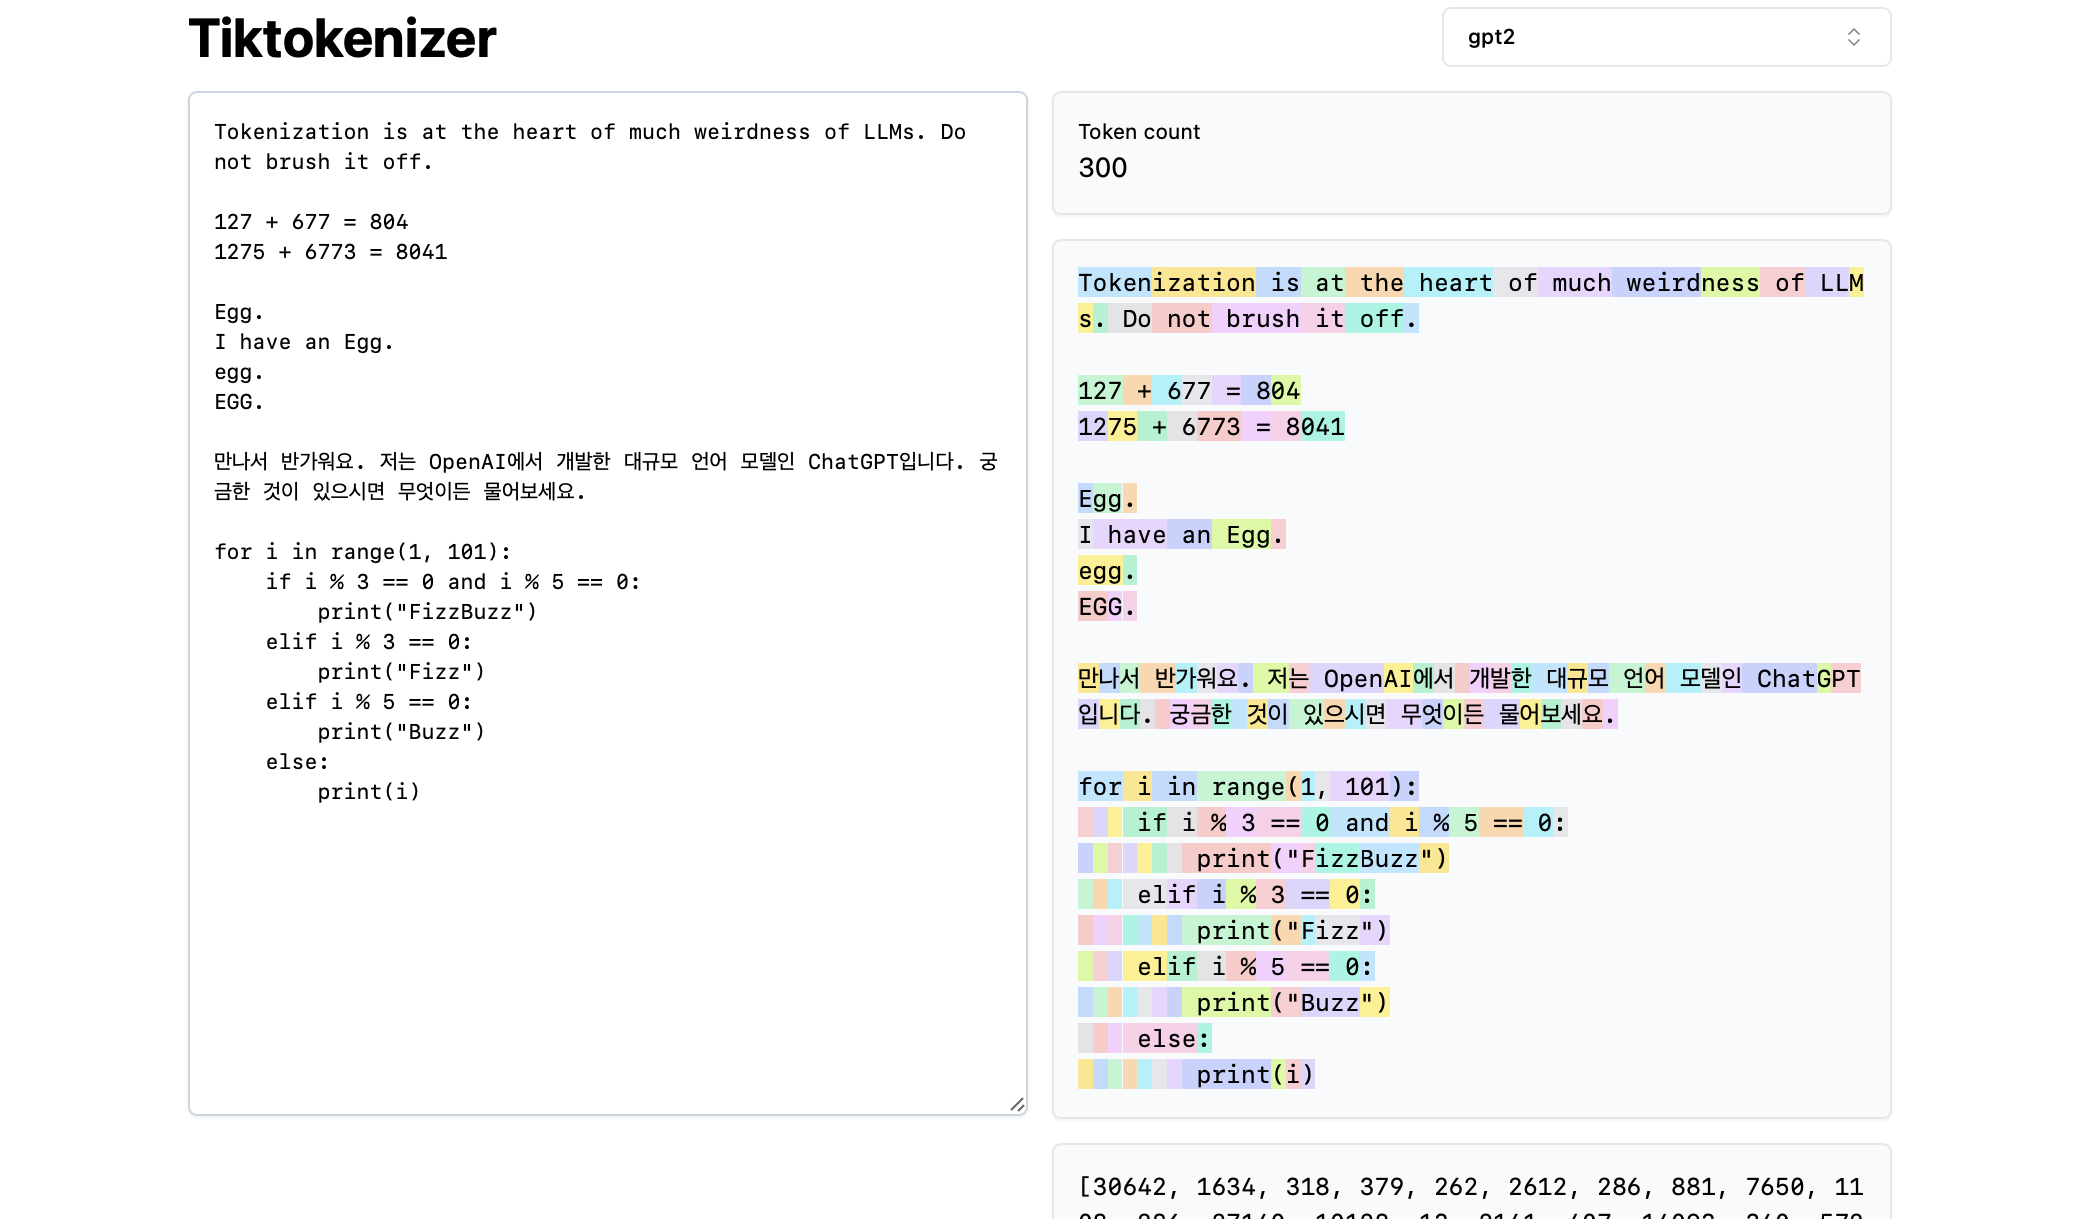<br><br><br><br>
So for example, the string "Tokenization" encoded into the tokens 30642 followed by the token 1634. The token " is" (note that these is three characters, including the space in the front, this is important!) is index 318. Be careful with whitespace because it is absolutely present in the string and must be tokenized along with all the other characters, but is usually omitted in visualization for clarity. You can toggle on and off its visualization at the bottom of the app. In the same way, the token " at" is 379, " the" is 262, etc.

Next, we have a simple example of some arithmetic. Here, we see that numbers may be inconsistently decomposed by the tokenizer. For example, the number 127 is a single token of three characters, but the number 677 because two tokens: the token " 6" (again, note the space in the front!) and the token "77". We rely on the large language model to make sense of this arbitrariness. It has to learn inside its parameters and during training that these two tokens (" 6" and "77" actually combine to create the number 677). In the same way, we see that if the LLM wanted to predict that the result of this sum is the number 804, it would have to output that in two time steps: first it has to emit the token " 8", and then the token "04". Note that all of these splits look completely arbitrary. In the example right below, we see that 1275 is "12" followed by "75", 6773 is actually two tokens " 6", "773", and 8041 is " 8", "041".

(to be continued...)
(TODO: may continue this unless we figure out how to generate it automatically from the video :))

---
<br><br>
# 2. **Strings** in Python: Unicode Code Points <a id='2'></a>
---
Let's discuss the process of tokenizing strings into integers for use with large language models, specifically for dealing with various languages and special characters such as Korean characters and Emojis. _**Strings**_ are immutable sequences of [<u>Unicode code points.</u>](https://docs.python.org/3/library/stdtypes.html#textseq). According to [wikipedia](https://en.wikipedia.org/wiki/Unicode), _**Unicode,**_ formally The Unicode Standard, is a text encoding standard maintained by the Unicode Consortium designed to support the use of text in all of the world's writing systems that can be digitized. Version $\textbf{15.1}$ of the standard defines $\textbf{149813}$ **characters** and $\textbf{161}$ **scripts** used in various ordinary, literary, academic, and technical contexts.

In [1]:
"안녕하세요 👋 (hello in Korean!)"

'안녕하세요 👋 (hello in Korean!)'

In [2]:
ord("h"), ord("👋"), ord("안")

(104, 128075, 50504)

In [3]:
#ord("hello")  #TypeError: ord() expected a character, but string of length 5 found

In [4]:
[ord(x) for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

---
<br><br>
# 3. Unicode Byte Encodings: `ASCII`, `UTF-8`, `UTF-16`, `UTF-32`<a id='3'></a>
---

**Strings** are immutable sequences of Unicode code points but since **Unicode is constantly updated and has a large vocabulary of over 150,000 characters,** we therefore turn to encodings instead. According to [wikipedia](https://en.wikipedia.org/wiki/Unicode) _**Unicode byte encodings**_ define how we translate Unicode's abstracted codes for characters into sequences of bytes. Unicode text is processed and stored as binary data/byte streams using these Unicode byte encodings. The Unicode Standard itself defines three encodings: `UTF-8`, `UTF-16`, and `UTF-32`, though several others exist. Of these, `UTF-8` is the most widely used by a large margin, in part due to its backwards-compatibility with `ASCII`. `UTF-8` means **Unicode Transformation Format – 8 bit.**

`UTF-8` is used to convert Unicode text into binary data, which enables variable-length representations of Unicode code points. `UTF-8` is also preferred as it is backwards compatible with simpler encoding systems and is widely used on the internet for its flexibility in handling various character sets.

In [5]:
"안녕하세요 👋 (hello in Korean!)".encode("utf-8")

b'\xec\x95\x88\xeb\x85\x95\xed\x95\x98\xec\x84\xb8\xec\x9a\x94 \xf0\x9f\x91\x8b (hello in Korean!)'

The code above gives an unintelligible output because it's in the form of a byte object. Let's convert it to a list to get the raw bytes of the encoding. Also let's look at `UT-16` and `UTF-32` encodings to see **how wasteful and inefficient they are for simple `ASCII` characters (english characters).**

In [6]:
print(list("안녕하세요 👋 (hello in Korean!)".encode("utf-8")))

[236, 149, 136, 235, 133, 149, 237, 149, 152, 236, 132, 184, 236, 154, 148, 32, 240, 159, 145, 139, 32, 40, 104, 101, 108, 108, 111, 32, 105, 110, 32, 75, 111, 114, 101, 97, 110, 33, 41]


In [7]:
for encoding in ["utf-16", "utf-32"]:
    print(encoding,": ", list("안녕하세요 👋 (hello in Korean!)".encode(encoding)), "\n")

utf-16 :  [255, 254, 72, 197, 85, 177, 88, 213, 56, 193, 148, 198, 32, 0, 61, 216, 75, 220, 32, 0, 40, 0, 104, 0, 101, 0, 108, 0, 108, 0, 111, 0, 32, 0, 105, 0, 110, 0, 32, 0, 75, 0, 111, 0, 114, 0, 101, 0, 97, 0, 110, 0, 33, 0, 41, 0] 

utf-32 :  [255, 254, 0, 0, 72, 197, 0, 0, 85, 177, 0, 0, 88, 213, 0, 0, 56, 193, 0, 0, 148, 198, 0, 0, 32, 0, 0, 0, 75, 244, 1, 0, 32, 0, 0, 0, 40, 0, 0, 0, 104, 0, 0, 0, 101, 0, 0, 0, 108, 0, 0, 0, 108, 0, 0, 0, 111, 0, 0, 0, 32, 0, 0, 0, 105, 0, 0, 0, 110, 0, 0, 0, 32, 0, 0, 0, 75, 0, 0, 0, 111, 0, 0, 0, 114, 0, 0, 0, 101, 0, 0, 0, 97, 0, 0, 0, 110, 0, 0, 0, 33, 0, 0, 0, 41, 0, 0, 0] 



While the benefits of `UTF-8` are clear, a significant limitation arises when using it naively for language modeling. The variable-length encoding results in a vocabulary size of only 256 possible tokens, which can lead to inefficiencies in processing long sequences, particularly in the context of transformer models with constrained attention spans.

To address these issues of limited vocabulary and longer byte sequences, the **Byte Pair Encoding (BPE)** algorithm is commonly employed as a solution for compressing byte sequences efficiently and expanding the vocabulary size, while retaining the advantages of `UTF-8` encoding. This allows us to support a larger vocabulary size while sticking with the UTF-8 encoding.


---
<br><br>
# 4. Daydreaming: Deleting Tokenization <a id='4'></a>
---
In a perfect world, it'll be ideal to feed raw byte sequences into language models. Tokenization-free models with raw byte sequences face challenges due to attention span limits in Transformers. This [paper](https://arxiv.org/abs/2305.07185) talks about a modified hierarchical Transformer structure to allow for tokenization-free autoregressive sequence language modeling. However, this approach has not yet been widely proven or fully validated, so we must rely on compression techniques like the BPE algorithm for now.


**Paper $\rightarrow$ "MEGABYTE: Predicting Million-byte Sequences with Multiscale Transformers"**

**Abstract**:
>Autoregressive transformers are spectacular models for short sequences but scale poorly to long sequences such as high-resolution images, podcasts, code, or books. We proposed `MEGABYTE`, a multi-scale decoder architecture that enables end-to-end differentiable modeling of sequences of over one million bytes. `MEGABYTE` segments sequences into patches and uses a _local_ submodel within patches and a _global_ model between patches. This enables sub-quadratic self-attention, much larger feedforward layers for the same compute, and improved parallelism during decoding $-$ unlocking better performance at reduced cost for both training and generation. Extensive experiments show that `MEGABYTE` allows byte-level models to perform competitively with subword models on long context language modeling, achieve state-of-the-art density estimation on ImageNet, and model audio from raw files. Together, these results establish the viability of tokenization-free autoregressive sequence modeling at scale.

---
<br><br>
# 5. **Byte Pair Encoding (BPE)** <a id='5'></a>
---
**Byte pair encoding** is an algorithm, first described in 1994 by Philip Gage for encoding strings of text into tabular form via iterative compression for use in downstream modeling. It is a powerful algorithm used for compressing and tokenizing text data. The algorithm works by iteratively merging the most frequent pair of consecutive tokens (bytes or characters) into a new token. This process continues until the desired vocabulary size is reached, resulting in a compressed representation of the original text.

All the unique tokens found in a corpus are listed in a token vocabulary, the size of which, in the case of **GPT-3.5** and **GPT-4,** is $\textbf{100256}$.

## [What is BPE anyway?](https://github.com/openai/tiktoken/blob/main/README.mdhttps://github.com/openai/tiktoken/blob/main/README.md)

Language models don't see text like you and I, instead they see a sequence of numbers (known as tokens).
Byte pair encoding (BPE) is a way of converting text into tokens. It has a couple desirable
properties:
1. It's reversible and lossless, so you can convert tokens back into the original text
2. It works on arbitrary text, even text that is not in the tokeniser's training data
3. It compresses the text: the token sequence is shorter than the bytes corresponding to the
   original text. On average, in practice, each token corresponds to about 4 bytes.
4. It attempts to let the model see common subwords. For instance, "ing" is a common subword in
   English, so BPE encodings will often split "encoding" into tokens like "encod" and "ing"
   (instead of e.g. "enc" and "oding"). Because the model will then see the "ing" token again and
   again in different contexts, it helps models generalise and better understand grammar.

`tiktoken` contains an educational submodule that is friendlier if you want to learn more about
the details of BPE, including code that helps visualise the BPE procedure:
```python
from tiktoken._educational import *

# Train a BPE tokeniser on a small amount of text
enc = train_simple_encoding()

# Visualise how the GPT-4 encoder encodes text
enc = SimpleBytePairEncoding.from_tiktoken("cl100k_base")
enc.encode("hello world aaaaaaaaaaaa")
```
---
## Original algorithm

The original algorithm operates by iteratively replacing the most common contiguous sequences of characters in a target text with unused 'placeholder' bytes. The iteration ends when no sequences can be found, leaving the target text effectively compressed. Decompression can be performed by reversing this process, querying known placeholder terms against their corresponding denoted sequence, using a lookup table. In the original paper, this lookup table is encoded and stored alongside the compressed text.

### Example

Suppose the data to be encoded is

```python
aaabdaaabac
```
The byte pair "aa" occurs most often, so it will be replaced by a byte that is not used in the data, such as "Z". Now there is the following data and replacement table:
    
```python
ZabdZabac 
Z=aa
```

Then the process is repeated with byte pair "ab", replacing it with "Y":
    
```python
ZYdZYac  
Y=ab  
Z=aa
```

The only literal byte pair left occurs only once, and the encoding might stop here. Alternatively, the process could continue with recursive byte pair encoding, replacing "ZY" with "X":
    
```python
XdXac  
X=ZY  
Y=ab  
Z=aa
```

This data cannot be compressed further by byte pair encoding because there are no pairs of bytes that occur more than once. To decompress the data, simply perform the replacements in the reverse order.

---
## 5.0. Implementation <a id='500'></a>
---

Let's take the 1st paragraph of this blog post: [A Programmer’s Introduction to Unicode](https://www.reedbeta.com/blog/programmers-intro-to-unicode/#utf-8) and use it as text input to implement BPE.

In [8]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/#utf-8
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0...255 for convenience
print('---')
print(text)
print("length:", len(text))
print('---')
print(tokens)
print("length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

---
## 5.1. Counting Consecutive Pairs, Finding the Most Common Pair<a id='501'></a>
---

In [9]:
def count_pairs(tokens:list):
    counts = {}
    for pair in zip(tokens, tokens[1:]):         # Pyhtonic way to Iterate over consecutive elements
        counts[pair] = counts.get(pair, 0) + 1   # Increment the count for each pair
    return counts                                # Return the dictionary containing all consecutive pairs and their counts


pairs = count_pairs(tokens)
# print(pairs)
# print(sorted([(v, k) for k,v in pairs.items()], reverse=True))

In [10]:
top_pair = max(pairs, key=pairs.get)
top_pair

(101, 32)

In [11]:
chr(101), chr(32)

('e', ' ')

---
## 5.2. Merging the Most Common Pair<a id='502'></a>
---

We merge the most common pair in our token vocabulary. In our case that's **(101, 32),** so therefore we shouldn't see that pair in our new token list. Instead we should see **256,** our replacement token. This should reduce our token vocabulary size from $\textbf{616}$ to $\textbf{596}$. 

The `merge` function iterates through the input list of tokens, checking if the current pair matches the target pair. If so, it appends the new token index to the merged token list; otherwise, it adds the current token as is.

By repeatedly applying this `merge` function, we can progressively compress the token sequence and expand the vocabulary.


In [12]:
def merge(tokens:list, target_pair:tuple, new_idx:int):
    merged_tokens = []                                                   # Initialize an empty list to store the modified elements
    i = 0                                                                # Start the loop index at 0             

    while i < len(tokens):                                               # Loop through `tokens` until the end of the list
        if i < len(tokens) - 1 and tokens[i:i+2] == list(target_pair):   # Check if we are not at the very last position AND if consecutive elements match the target pair
            merged_tokens.append(new_idx)                                # Replace the checked pair with the new token idx
            i += 2                                                       # Skip the next 2 elements (pair) 
        else:
            merged_tokens.append(tokens[i])                              # Add the current element if no match
            i += 1                                                       # Skip the next element

    return merged_tokens



print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

tokens2 = merge(tokens, top_pair, 256)
print("\n", tokens2)
print("length:", len(tokens2))

[5, 6, 99, 9, 1]

 [239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111

---
## 5.3. Training the Tokenizer: **while loop, compression ratio**<a id='503'></a>
---
The process of refining a tokenizer through Byte Pair Encoding (BPE) involves an iterative approach, where the most frequently occurring byte pairs in a sequence are identified and replaced with new tokens. This systematic compression allows for the expansion of the vocabulary while reducing the length of the input sequence.

To implement this iterative refinement, we'll go through the following steps:

1.  **Initialize the Sequence**: Let's start with a sample sequence of tokens, such as `[5, 6, 6, 7, 9, 1]`.
2.  **Identify the Most Frequent Pair**: We'll use a function `count_pairs` to count the occurrences of each pair of consecutive tokens in the sequence. The pair with the highest frequency will be the target for merging.
3.  **Replace the Pair with a New Token**: We'll use a function `merge` to replace these two tokens with a new token. In our example, let's assume the most frequent pair is `(6, 7)`. We can replace it with a new token, say `99`, to create a new sequence: `[5, 99, 9, 1]`.
4.  **Repeat the Process**: We'll continue this process, iteratively finding the most frequent pair and replacing it with a new token, until we reach our desired vocabulary size.

Token merging involves finding the most occurring pair and replacing it with a new token integer. Individual tokens can still exist in the sequence after merging, becoming the new token only when they occur consecutively. After $\textbf{20}$ merges, a compression ratio of roughly $\textbf{1.27}$ was achieved, reducing the token list size from $\textbf{24,000}$ to $\textbf{19,000}$ bytes.

In [13]:
# making the training text longer to have more representative token statistics As of March 3, 2017
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience

In [14]:
def count_pairs(tokens:list):
    counts = {}
    for pair in zip(tokens, tokens[1:]):         # Pyhtonic way to Iterate over consecutive elements
        counts[pair] = counts.get(pair, 0) + 1   # Increment the count for each pair
    return counts                                # Return the dictionary containing all consecutive pairs and their counts


def merge(tokens:list, target_pair:tuple, new_idx:int):
    merged_tokens = []                                                   # Initialize an empty list to store the modified elements
    i = 0                                                                # Start the loop index at 0             

    while i < len(tokens):                                               # Loop through `tokens` until the end of the list
        if i < len(tokens) - 1 and tokens[i:i+2] == list(target_pair):   # Check if we are not at the very last position AND if consecutive elements match the target pair
            merged_tokens.append(new_idx)                                # Replace the checked pair with the new token idx
            i += 2                                                       # Skip the next 2 elements (pair) 
        else:
            merged_tokens.append(tokens[i])                              # Add the current element if no match
            i += 1                                                       # Skip the next element

    return merged_tokens


# ---
vocab_size = 276 # the desired final vocabulary size
num_merges = vocab_size - 256
ids = list(tokens) # copy so we don't destroy the original list

merges = {} # (int, int) -> int
for i in range(num_merges):
    stats = count_pairs(ids)
    pair = max(stats, key=stats.get)
    idx = 256 + i
    print(f"merging {pair} into a new token {idx}")
    ids = merge(ids, pair, idx)
    merges[pair] = idx

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (101, 114) into a new token 260
merging (99, 111) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (111, 114) into a new token 266
merging (100, 32) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (261, 100) into a new token 271
merging (121, 32) into a new token 272
merging (46, 32) into a new token 273
merging (97, 108) into a new token 274
merging (259, 256) into a new token 275


In [15]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 24597
ids length: 19438
compression ratio: 1.27X


This iterative process of finding and replacing the most frequent pairs continues until the target vocabulary size is reached. The resulting tokenizer will have a more compressed representation, facilitating efficient processing and storage of the input text.

By carefully tuning the hyperparameters, such as the **number of merges** and the **target vocabulary size,** we can optimize the tokenizer's performance for our specific use case.


---
<br><br>
# 6. Tokenizer/LLM Diagram <a id='6'></a>
---
Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

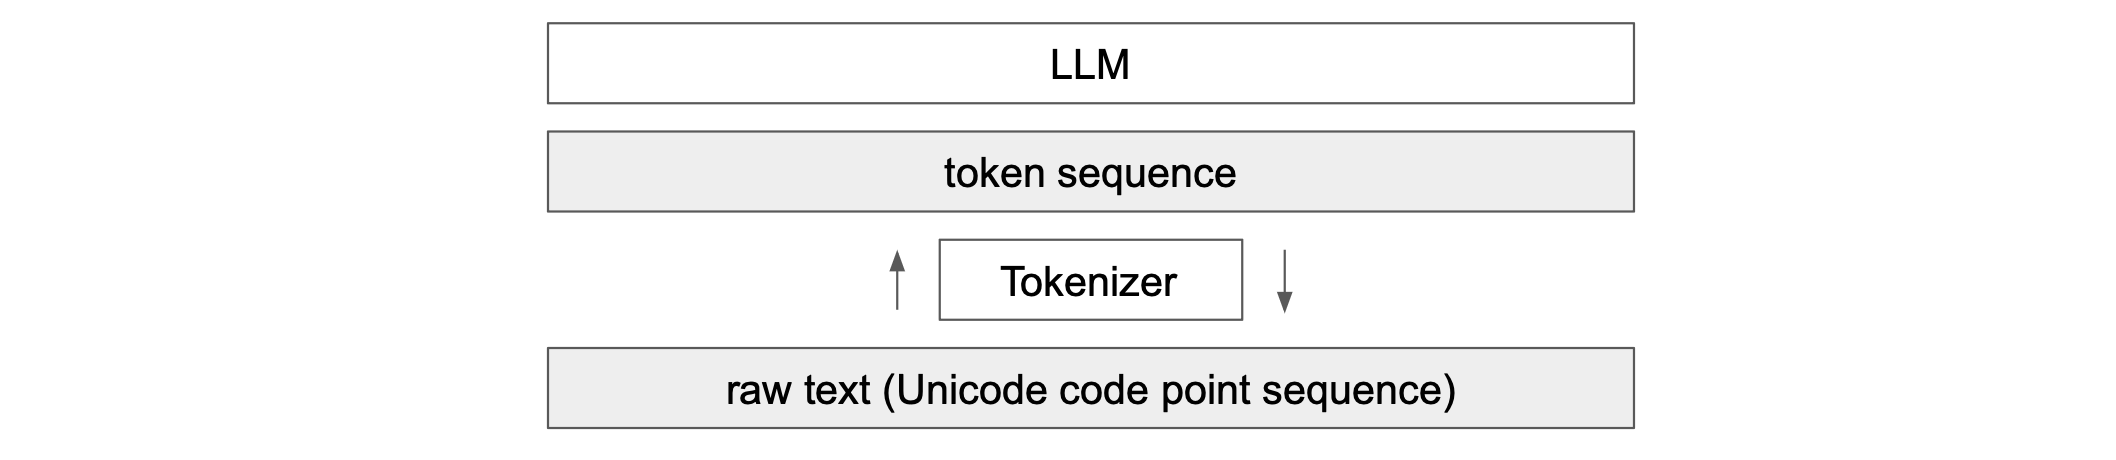

The tokenizer is a separate entity from the language model, undergoing training with Byte Pair Encoding algorithm for vocabulary creation. Once trained, the tokenizer enables encoding and decoding processes for text.

Language model training involves translating data between token sequence and raw text. Training data is processed through a tokenizer to create token sequences for the language model. The tokenizer helps in encoding and decoding raw text into token sequences and vice versa. Different languages in the tokenizer training set impact token merging and sequence lengths. Implementing a mapping from token IDs to bytes objects aids in the encoding and decoding process.




## Tokenizer Training and Usage

The process of training a tokenizer used for natural language processing is a critical step in the development of any large language model (LLM). The tokenizer plays a vital role in text compression and the conversion between raw text and token sequences, which are the fundamental building blocks for these powerful models.

### Training the Tokenizer

The training of a tokenizer is typically conducted separately from the training of the language model itself. This separation allows for the tokenizer to be optimized for handling diverse data, such as multiple languages and text types, including code. The diversity and composition of the training data used for the tokenizer can have a significant impact on its efficiency and effectiveness. The training process begins by collecting a vast amount of training data, which is then run through the tokenizer to produce a sequence of tokens. This token sequence effectively replaces the original raw text, as the tokenizer's output becomes the input for the subsequent language model training. It's important to note that the tokenizer's training dataset may differ from the dataset used for the language model. For instance, incorporating a larger volume of a specific language, such as Japanese, into the tokenizer's training set will result in more tokens being created for that language. This can be beneficial for the LLM, as it will lead to shorter sequences for Japanese text, which is advantageous due to the finite context length when processing inputs.

```
+----------+        +----------+        +----------------+        +----------------+
| Raw Text | -----> | Tokenizer| -----> | Token Sequence | -----> | Language Model |
+----------+        +----------+        +----------------+        +----------------+
```

The separation between the tokenizer and the language model is a crucial aspect to understand. The tokenizer's training design is pivotal in determining the density and variety of tokens, which in turn impacts the performance and efficiency of the language model.

### Encoding and Decoding with the Trained Tokenizer

Once the tokenizer has been trained, it can be used to convert raw text into a sequence of tokens and vice versa. This encoding and decoding process is a fundamental operation in the utilization of language models. Ensuring the effectiveness and reliability of the encoding and decoding operations is crucial for the successful integration of the tokenizer into the overall language model pipeline.


---
<br><br>
# 7. **Decoder:** Tokens to Strings <a id='7'></a>
---
The decoding process takes a sequence of token IDs and converts it back into a Python string object. This is achieved by maintaining a mapping, or "vocab," that associates each token ID with its corresponding byte representation. By concatenating these byte representations, the original string can be reconstructed.

It's important to note that the decoding process can be complex, as not all token sequences may form valid byte streams, particularly when dealing with UTF-8 encoding. Handling these invalid token sequences requires special attention to ensure the process remains robust and compliant with the UTF-8 standard.

**Given a sequence of integers in the range [0, vocab_size], what is the text?**

<u>Steps:</u> (Aside: Python 3.7 guarantees dictionary iteration order, crucial for creating tokens.)
* Iterating over `ids` , looking up bytes, then concatenating creates `tokens`.
* Decoding raw bytes to strings using UTF-8 for final text output.



<u>Note:</u> An issue may arise with specific `id` sequences, causing decoding errors.
>Example: Decoding 128 triggers an error due to an invalid start byte.

In [16]:
# Suppose you have the following vocab and merges defined:
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]

# Decode a list of token ids: given ids (list of integers), return Python string
def decode(ids):
    tokens = b"".join(vocab[idx] for idx in ids)           # Concatenate byte sequences for each token
    text = tokens.decode("utf-8")        # Decode bytes to string
    return text

# print(decode([128]))  # Example usage to see error for invalid tokens 
#output: UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

The `decode` function provided for decoding token sequences into text has an issue that can lead to an error if it encounters certain "unlucky" sequences of token IDs. Specifically, when trying to decode a single token like `128`, the UTF-8 decoder in Python may throw an error because `128` does not conform to the UTF-8 encoding scheme. 

### Explanation:
- **UTF-8 Encoding**: UTF-8 has a specific schema for how bytes represent characters, especially for multi-byte sequences. The byte `128` in binary (`10000000`) is not a valid start byte in UTF-8 encoding. Valid UTF-8 sequences require a specific pattern, and `128` does not meet these requirements, leading to an _**"invalid start byte"**_ error.

### Solution:
- **Error Handling**: To avoid errors when decoding, it's common practice to use the `errors='replace'` parameter in the `decode` function as explained in the [bytes & bytearray operations](https://docs.python.org/3/library/stdtypes.html#bytes-and-bytearray-operations) and [error handling](https://docs.python.org/3/library/codecs.html#error-handlers) sections of the official Python documentation. This tells Python to replace invalid byte sequences with a special replacement character (�) instead of throwing an error. This method is standard and even used in implementations like OpenAI's code.

### Summary:
To handle cases where token sequences don't conform to UTF-8 standards, use `errors='replace'` in the decoding process. This ensures that the program doesn't crash and instead replaces invalid sequences with a marker, indicating that the language model output contained an invalid sequence of tokens.

In [17]:
# Suppose you have the following vocab and merges defined:
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]

# Decode a list of token ids: given ids (list of integers), return Python string
def decode(ids):
    tokens = b"".join(vocab[idx] for idx in ids)           # Concatenate byte sequences for each token
    text = tokens.decode("utf-8", errors="replace")        # Decode bytes to string
    return text

print(decode([128]))  # Example usage

�


---
<br><br>
# 8. **Encoder:** Strings to Tokens <a id='7'></a>
---
The encoding process involves first encoding the input string into a sequence of bytes using UTF-8 encoding. These bytes are then transformed into a list of integers, representing the corresponding token IDs. This list of token IDs serves as the input for the language model.

The `encode` function identifies the pair to merge at each stage of a loop. It uses Python's `min` function to find the pair with the lowest index in the `merges` dictionary. The function iterates through the keys of the `stats` dictionary, which represent pairs of tokens from `count_pairs`. For each pair, it checks its index in the `merges` dictionary using the `min` function. The pair with the minimum index is selected as the merging candidate. If no pairs are eligible for merging, the function might return an arbitrary pair as an indication that no more merges are possible. Once a merging candidate is identified, the pair is merged according to the index in the `merges` dictionary, and the list of tokens is updated. This process continues until no further merges can be made, at which point the updated list of tokens is returned.

**The other way around: Given a string, what are the tokens?**

<u>Steps:</u>
Here are the steps for the `encode` function:

1. **Convert Text to Tokens:**
   - Convert the input text into a list of integers representing the UTF-8 encoded bytes.

2. **Count Token Pairs:**
   - Count the frequency of pairs of consecutive tokens in the list.

3. **Find the Least Merged Pair:**
   - Identify the token pair with the minimum merge cost from a pre-defined dictionary. If the pair is not in the dictionary, no further merging is possible.
   > - According to the merges dictionary, bytes may be merged based on a lookup. 
   > - Merges were built top to bottom to determine the order of insertion for merging. 
   > - Merging order from top to bottom is essential; earlier merges are prerequisites for later merges. 
   > - To reuse functionality, consecutive byte pairs are merged by identifying the lowest indexed key in the stats dictionary.
   > - Using `min` over an iterator in Python to find the pair with the minimum value inside a dictionary.
   > - Identifying and returning the most eligible merging candidate pair from a list of tokens.
   > - A float INF value `float("inf")` is used as a fallback for pairs that cannot be merged.

4. **Merge Token Pair:**
   - If the token pair is found in the dictionary, merge the pair in the token list according to the merge index specified in the dictionary.

5. **Repeat or Return:**
   - Repeat steps 2-4 while there are at least two tokens left. If no more merges are possible, return the final list of tokens.


In [18]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}

In [19]:
def encode(text: str):
    # Convert the input text into a list of byte values (tokens)
    tokens = list(text.encode("utf-8"))
    
    # Iterate over each merge operation to gradually encode the text
    for (p0, p1), idx in merges.items():
        target_pair = (p0, p1)
        tokens = merge(tokens, target_pair, idx)  # Apply the merge step
    
    return tokens

print(encode("h"))

[104]


In [20]:
# def encode(text):
#     # given a string, return list of integers (the tokens)
#     tokens = list(text.encode("utf-8"))
#     while len(tokens) >= 2:
#         stats = count_pairs(tokens)
#         pair = min(stats, key=lambda p: merges.get(p, float("inf")))
#         if pair not in merges:
#             break # nothing else can be merged
#         idx = merges[pair]
#         tokens = merge(tokens, pair, idx)
#     return tokens

# print(encode("h"))

In [21]:
print(decode(encode("hello world")))

hello world


In [22]:
text2 = decode(encode(text))
print(text2 == text)

True


In [23]:
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = decode(encode(valtext))
print(valtext2 == valtext)

True


---
<br><br>
# 9. `Regex` Patterns: To Force Splits across Categories (`GPT` Series) <a id='9'></a>
---
Let's dive into the nitty-gritty of enforcing character merging rules on byte pair encoding. GPT-2 tokenizer enforces these merging rules by using pattern matching (regex). Let's discuss the importance of Regular Expression (`regex`) patterns in tokenization and how they can help enforce rules for what part fo text will not be merged. Python's `regex` library is like the supercharged version/extension of the classic Python `re` module for pattern matching. We'll focus on GPT-2 tokenizer implementation.

## Detailed Analysis of GPT-2 Tokenizer Implementation

### Overview
The GPT-2 tokenizer uses a sophisticated approach to text tokenization, combining byte pair encoding (BPE) with custom rules to prevent undesired merges.

### Key Components

1. **Regex Pattern for Text Chunking**
   - Uses a complex regex pattern to split text before applying BPE
   >```python
   >gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
   >```
   - Implemented in `encoder.py` in the GPT-2 GitHub repository
   - Uses the `regex` Python package, an extension of the standard `re` module

2. **Chunking Process**
   - Splits text into a list of chunks
   - Each chunk is processed independently by the tokenizer
   - Results are concatenated to form the final token sequence

3. **Merge Prevention**
   - The chunking process prevents merges between certain character types:
     - Letters
     - Numbers
     - Punctuation
     - Specific apostrophe cases

4. **Regex Pattern Breakdown**
   - Matches letters, numbers, specific apostrophe cases, and punctuation separately
   - Uses Unicode character classes (e.g., `\p{L}` for letters, `\p{N}` for numbers)
   - Special handling for whitespace to maintain consistency in tokenization

5. **Apostrophe Handling**
   - Hardcoded for specific apostrophe cases (e.g., `'s, 't, 'd, 'll, 'm, 've, 're`)
   - Case-sensitive, leading to inconsistent tokenization of uppercase/lowercase contractions
   - Does not handle Unicode apostrophes consistently

6. **Whitespace Handling**
   - Uses a negative look-ahead assertion to handle multiple spaces
   - Preserves a single space before words/numbers for consistent tokenization

### Limitations and Quirks

1. **Inconsistent Case Handling**
   - Tokenization differs for uppercase and lowercase versions of the same word with apostrophes

2. **Language Specificity**
   - Apostrophe handling is tailored to English, potentially causing issues with other languages

3. **Undocumented Rules**
   - Some tokenization behaviors (e.g., never merging spaces) are not explicitly documented

4. **Training Process Opacity**
   - The exact training process for the tokenizer is not public
   - Only inference code is available, not the training code

### Conclusion
The GPT-2 tokenizer implementation is more complex than a straightforward application of BPE. It incorporates various rules and heuristics to improve tokenization quality, but also introduces some inconsistencies and potential issues with certain types of text.

In [24]:
import regex as re
# code below is line 53 from https://github.com/openai/gpt-2/blob/master/src/encoder.py
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

for i in ["Hello world", "Hello world how are you", "Hello world123 how are you", "Hello've world123 how's are you!!!?"]:
    print(re.findall(gpt2pat, i))

['Hello', ' world']
['Hello', ' world', ' how', ' are', ' you']
['Hello', ' world', '123', ' how', ' are', ' you']
['Hello', "'ve", ' world', '123', ' how', "'s", ' are', ' you', '!!!?']


In [25]:
for i in ["Hello've world123 how′s are you!!!?", "Hello've world123 how's are     you!!!?    ","Hello've world123 how's are you!!!?"]:
    print(re.findall(gpt2pat, i))

['Hello', "'ve", ' world', '123', ' how', '′', 's', ' are', ' you', '!!!?']
['Hello', "'ve", ' world', '123', ' how', "'s", ' are', '    ', ' you', '!!!?', '    ']
['Hello', "'ve", ' world', '123', ' how', "'s", ' are', ' you', '!!!?']


In [26]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2pat, example))

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


---
<br><br>
# 10. Introduction: `tiktoken` library, Differences btw GPT2 & GPT4 `Regex` <a id='10'></a>
---
[Tiktoken](https://github.com/openai/tiktoken) is a fast BPE tokenizer for use with OpenAI's models.

## Tiktoken Library and Special Tokens in GPT Models

### Tiktoken Library
- Official tokenization library from OpenAI
- Used for tokenization inference (not training)
- Implements tokenizers for various GPT models (GPT-2, GPT-4, etc.)

### Tokenizer Changes from GPT-2 to GPT-4
1. Whitespace handling:
   - **GPT-2:** Whitespaces remain unmerged
   - **GPT-4:** Whitespaces can be merged
2. Regular expression for text chunking:
   - Case-insensitive matching in **GPT-4** (fixes inconsistencies with contractions)
   - Different handling of whitespace; Improved whitespace handling in **GPT-4**
   - Numbers/numeric sequences limited to 1-3 digits for merging in **GPT-4** to prevent excessively long tokens
3. Vocabulary size:
   - **GPT-2:** ~$\textbf{50k}$ tokens
   - **GPT-4:** ~$\textbf{100k}$ tokens

### Special Tokens
- Tokens outside the standard byte pair encoding (BPE) algorithm
- Used to delimit parts of data or create special structure in token streams
- Handled by special case instructions in the tokenizer

#### Examples of Special Tokens:
1. **GPT-2:**
   - End of text (EOT) token: Used to delimit documents in the training set
2. **GPT-4:**
   - EOT token `<|endoftext|>`
   - Fill-in-the-middle (FIM) tokens: prefix, middle, and suffix
   - An additional unspecified token

#### Adding Special Tokens:
- Can be added to extend existing tokenizers
- Requires model surgery to adjust the transformer architecture:
  - Extending the embedding matrix
  - Adjusting the final layer projection

### Tiktoken Implementation Details
- Implemented in Rust for efficiency
- Allows for extension and addition of custom special tokens
- Provides functionality to fork existing tokenizers (e.g., `CL100K` base used in GPT-4)

### Importance in Fine-tuning
- Special tokens are crucial when fine-tuning models for specific tasks (e.g., creating chat models like ChatGPT)
- Used to structure conversations and delimit different parts of the input

### Note on Documentation
- Many implementation details and decisions are not fully documented by OpenAI

In [27]:
!pip install tiktoken # added for colab

In [28]:
import tiktoken

# GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("    hello world!!!"))

# GPT-4 (merges spaces)
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("    hello world!!!"))

[220, 220, 220, 23748, 995, 10185]
[262, 24748, 1917, 12340]


---
<br><br>
# 11. OpenAI GPT2 `encoder.py`: Walkthrough<a id='11'></a>
---

The GPT-2 `encoder.py` [file](https://github.com/openai/gpt-2/blob/master/src/encoder.py) from OpenAI is relatively short and understandable. It focuses on loading and processing two key files $-$ `encoder.json` and `vocab.bpe` $-$ to create a tokenizer object. 

Key points:
>- OpenAI's `encoder.json` = Our `vocab` in [Section 7](#7)
>- OpenAI's `vocab.bpe` = Our `merges`in [Section 5.3](#503)
- The `encoder.json` and `vocab.bpe` files constitute the saved tokenizer.
- The `encoder` object is equivalent to the `vocab` object, mapping integers to bytes.
- The `vocab.bpe` file contains the BPE merges, equivalent to the `merges` variable.
- These two variables (`merges` and `vocab`) are crucial for representing a tokenizer and performing both encoding and decoding once trained.
- OpenAI's implementation includes a separate `byte_encoder` and `byte_decoder`, which aren't particularly significant to understanding the core tokenizer functionality.
- The meat of the file is the BPE function, which is algorithmically similar to the previously discussed implementation. It features a loop to identify bigrams for merging and another loop to perform the merges throughout the sequence.
- The file includes encode and decode functions, similar to those implemented earlier.

The GPT-2 `encoder.py` file is algorithmically identical to the BPE tokenizer built earlier. The OpenAI implementation has some additional complexity, but the core algorithm is the same. In essence, despite some differences in naming and structure, the OpenAI implementation is algorithmically identical to the previously built tokenizer. Understanding the core concepts of building, training, encoding, and decoding with a BPE tokenizer remains the key takeaway and is sufficient to understand the GPT-2 tokenizer.

Reference the GPT-2 [encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
Download the vocab.bpe and encoder.json files.

In [29]:
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
!wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

--2024-08-28 08:05:26--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 57.150.97.129
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|57.150.97.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 456318 (446K) [application/octet-stream]
Saving to: 'vocab.bpe.1'

vocab.bpe.1         100%[===================>] 445.62K  1.12MB/s    in 0.4s    

2024-08-28 08:05:27 (1.12 MB/s) - 'vocab.bpe.1' saved [456318/456318]

--2024-08-28 08:05:28--  https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 57.150.97.129
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|57.150.97.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [application/json]
Sav

In [30]:
import os, json

with open('encoder.json', 'r') as f:
    encoder = json.load(f) # <--- ~equivalent to our "vocab"

with open('vocab.bpe', 'r', encoding="utf-8") as f:
    bpe_data = f.read()
bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
# ^---- ~equivalent to our "merges"


In [31]:
bpe_merges

[('Ġ', 't'),
 ('Ġ', 'a'),
 ('h', 'e'),
 ('i', 'n'),
 ('r', 'e'),
 ('o', 'n'),
 ('Ġt', 'he'),
 ('e', 'r'),
 ('Ġ', 's'),
 ('a', 't'),
 ('Ġ', 'w'),
 ('Ġ', 'o'),
 ('e', 'n'),
 ('Ġ', 'c'),
 ('i', 't'),
 ('i', 's'),
 ('a', 'n'),
 ('o', 'r'),
 ('e', 's'),
 ('Ġ', 'b'),
 ('e', 'd'),
 ('Ġ', 'f'),
 ('in', 'g'),
 ('Ġ', 'p'),
 ('o', 'u'),
 ('Ġa', 'n'),
 ('a', 'l'),
 ('a', 'r'),
 ('Ġt', 'o'),
 ('Ġ', 'm'),
 ('Ġo', 'f'),
 ('Ġ', 'in'),
 ('Ġ', 'd'),
 ('Ġ', 'h'),
 ('Ġan', 'd'),
 ('i', 'c'),
 ('a', 's'),
 ('l', 'e'),
 ('Ġt', 'h'),
 ('i', 'on'),
 ('o', 'm'),
 ('l', 'l'),
 ('en', 't'),
 ('Ġ', 'n'),
 ('Ġ', 'l'),
 ('s', 't'),
 ('Ġ', 're'),
 ('v', 'e'),
 ('Ġ', 'e'),
 ('r', 'o'),
 ('l', 'y'),
 ('Ġb', 'e'),
 ('Ġ', 'g'),
 ('Ġ', 'T'),
 ('c', 't'),
 ('Ġ', 'S'),
 ('i', 'd'),
 ('o', 't'),
 ('Ġ', 'I'),
 ('u', 't'),
 ('e', 't'),
 ('Ġ', 'A'),
 ('Ġ', 'is'),
 ('Ġ', 'on'),
 ('i', 'm'),
 ('a', 'm'),
 ('o', 'w'),
 ('a', 'y'),
 ('a', 'd'),
 ('s', 'e'),
 ('Ġth', 'at'),
 ('Ġ', 'C'),
 ('i', 'g'),
 ('Ġf', 'or'),
 ('a', 'c'),
 ('Ġ

---
<br><br>
# 12. Special Tokens in Language Models <a id='12'></a>
---

## Introduction
Special tokens are additional tokens inserted into the vocabulary of language models to delimit different parts of data or create special structures in token streams. They are used alongside tokens derived from raw bytes and BPE (Byte Pair Encoding) merges.
- Tokens outside the standard byte pair encoding (BPE) algorithm
- Used to delimit parts of data or create special structure in token streams
- Handled by special case instructions in the tokenize

## Key Points

### OpenAI's GPT-2 Encoder
- The encoder object has 50,257 tokens
- 256 raw byte tokens + 50,000 BPE merges + 1 special token
- The special token is `<|endoftext|>` (token ID 50256)

### Purpose of Special Tokens
- Delimit documents in the training set
- Signals the end of a document to the language model
- Create structure in conversations (e.g., in fine-tuned models like GPT-3.5 Turbo)

### Implementation Details
- Special tokens are handled outside the typical BPE encoding algorithm
- They are processed by special case instructions in the tokenizer implementation
- Can be found in libraries like `tiktoken` (implemented in [Rust](https://github.com/openai/tiktoken/blob/main/src/lib.rs) for efficiency)
    - Allows for extension and addition of custom special tokens
    - Provides functionality to fork existing tokenizers (e.g., `CL100K` base used in GPT-4)

### Adding Special Tokens
- Possible to extend existing tokenizers with custom special tokens
- Requires "model surgery" to adjust the transformer's parameters:
  - Extending the embedding matrix
  - Adjusting the final layer projection

### Examples of Special Tokens
- **GPT-2:** `<|endoftext|>`
- **GPT-4:** `<|endoftext|>`, `<|fim_prefix|>`, `<|fim_middle|>`, `<|fim_suffix|>`, and `<|endofprompt|>`
  - `FIM` stands for _**"Fill in the Middle"**_ and is explained in this [paper](https://arxiv.org/abs/2207.14255).

## Significance
Special tokens are crucial for:
1. Base language modeling (predicting the next token)
2. Fine-tuning stages for specific tasks (e.g., creating chat models like ChatGPT)
3. Structuring conversations in chat models like ChatGPT

## Note on Documentation
- Many implementation details and decisions are not fully documented by OpenAI

Understanding special tokens is essential for building and customizing language model tokenizers, especially when adapting models for specific tasks or creating chat-based interfaces.

In [32]:
len(encoder) # 256 raw byte tokens. 50,000 merges. +1 special token

50257

In [33]:
encoder['<|endoftext|>'] # the only special token in use for the GPT-2 base model

50256

---
<br><br>
# 13. Exercise: Write your own GPT4 Tokenizer, `minBPE` <a id='13'></a>
---

### `minBPE` exercise

At this point you have everything you need to build your own GPT-4 tokenizer. This is the [exercise progression](https://github.com/karpathy/minbpe/blob/master/exercise.md) you may wish to follow. You'll note that it is part of the [minBPE](https://github.com/karpathy/minbpe) repo, which is the solution to that exercise, and is a cleaned up version of the code above.

---
## Building a GPT-4-like Tokenizer with minBPE

## Overview
The `minBPE` project provides a framework for building a tokenizer similar to GPT-4's, implementing both training and inference. This summary outlines the key aspects of the project and how to use it.

## Key Components

1. **`minBPE` Repository**:
   - Contains the implementation of a minimal Byte Pair Encoding (BPE) tokenizer.
   - Includes both training and inference code.
   - The repository is actively maintained and may evolve over time.

2. **Exercise Progression**:
   - A step-by-step guide ([exercise.md](https://github.com/karpathy/minbpe/blob/master/exercise.md)) breaks down the task of building a GPT-4-like tokenizer.
   - Consists of $4$ main steps that build up to a complete tokenizer.

3. **Functionality**:
   - Aims to reproduce behavior similar to `tiktoken` (OpenAI's tokenizer library).
   - Supports encoding and decoding of strings.
   - Implements a `train` function for creating custom token vocabularies.

4. **Vocabulary Comparison**:
   - `minBPE` visualizes token vocabularies, allowing comparison with GPT-4's merges.
   - The first $256$ tokens represent raw individual bytes.
   - Subsequent tokens show the order of merges during training.

## Usage Example

```python
# Hypothetical usage based on the description
from minbpe import Tokenizer

# Load or train a tokenizer
tokenizer = Tokenizer.load('gpt4-like')  # or Tokenizer.train(data)

# Encoding
text = "Hello, world!"
encoded = tokenizer.encode(text)

# Decoding
decoded = tokenizer.decode(encoded)
assert text == decoded

# Training a custom tokenizer
custom_tokenizer = Tokenizer.train(your_training_data)
```

## Training Insights
- The vocabulary learned depends on the training data.
- _Example:_ Training on a Wikipedia page about Taylor Swift produced similar, but not identical, merges to GPT-4.
- Differences in vocabularies reflect differences in training data (e.g., GPT-4 likely trained on more code).

## Conclusion
`minBPE` offers a practical way to understand and implement GPT-4-like tokenization. By following the provided exercises and referencing the `minBPE` code, users can build their own tokenizers and gain deeper insights into how modern language models process text.

In [34]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # GPT-4 tokenizer
print(enc.encode("안녕하세요 👋 (hello in Korean!)"))
print(enc.decode(enc.encode("안녕하세요 👋 (hello in Korean!)")) == "안녕하세요 👋 (hello in Korean!)")
# match the above for your own tokenizer, and also implement a train() function

[31495, 230, 75265, 243, 92245, 62904, 233, 320, 15339, 304, 16526, 16715]
True


## How to build your own GPT-4 tokenizer, 
---

The `minBPE` repository is a good reference point to start with. Here's a summary of what you might need to do based on the lecture:

### Steps to Build Your Own GPT-4 Tokenizer:
1. **Repository Setup:**
   - Clone the `minBPE` repository from GitHub, which the instructor has provided as a reference for building your tokenizer.
   - The repository includes a progression of exercises in `exercise.md` that will guide you through the process in four steps.

2. **Understand the BPE Algorithm:**
   - The `minBPE` repository uses the Byte Pair Encoding (BPE) algorithm, which is central to how tokenizers like GPT-4 are trained.
   - The BPE algorithm iteratively merges the most frequent pairs of bytes or characters in the training data to build the tokenizer vocabulary.

3. **Follow the Exercises:**
   - Work through the exercises in `exercise.md` to gradually build up your understanding and implementation of a GPT-4 style tokenizer.
   - The exercises are designed to break down the task into manageable steps.

4. **Reference the Code:**
   - If you get stuck, you can refer to the `minBPE` repository for guidance. The repository includes tests and clean, understandable code that you can use to troubleshoot your implementation.

5. **Reproduce Tiktoken Behavior:**
   - Your goal is to reproduce the behavior of OpenAI's `tiktoken` library, which is used for tokenization in GPT models.
   - Specifically, you should be able to encode a string into tokens and then decode it back to the original string using your custom tokenizer.

6. **Train Your Own Tokenizer:**
   - Unlike `tiktoken`, which only provides inference code, you will implement your own training function.
   - This function will allow you to train a tokenizer on your dataset, generating a custom vocabulary.

7. **Compare Your Results:**
   - After training your tokenizer, compare the vocabularies generated by your tokenizer with those from the GPT-4 tokenizer.
   - While the merge orders might differ depending on the training data, the overall structure and results should be similar if the same algorithm is applied.

8. **Example Visualization:**
   - The instructor provided an example where they trained a tokenizer on a Wikipedia page about Taylor Swift. They visualized the merges that occurred during training and compared them to the merges in GPT-4.
   - Use this as a benchmark to assess your own tokenizer's behavior.

### Moving Forward:
- Once you've completed these steps, you should have a fully functional tokenizer similar to the one used in GPT-4. 

---
<br><br>
# 14. Introduction: `sentencepiece` library <a id='14'></a>
---

### sentencepiece

Commonly used because (unlike tiktoken) it can efficiently both train and inference BPE tokenizers. It is used in both Llama and Mistral series.

[sentencepiece on Github link](https://github.com/google/sentencepiece).

Docs for sentencepiece options:

- [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
- [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

**The big difference**: sentencepiece runs BPE on the Unicode code points directly! It then has an option `character_coverage` for what to do with very very rare codepoints that appear very few times, and it either maps them onto an UNK token, or if `byte_fallback` is turned on, it encodes them with utf-8 and then encodes the raw bytes instead.

TLDR:

- tiktoken encodes to utf-8 and then BPEs bytes
- sentencepiece BPEs the code points and optionally falls back to utf-8 bytes for rare code points (rarity is determined by character_coverage hyperparameter), which then get translated to byte tokens.

(Personally I think the tiktoken way is a lot cleaner...)

---
## Overview
SentencePiece is a widely used library for tokenization in Large Language Models (LLMs), employed by models like LLaMa and Mistral. It supports both training and inference efficiently and offers multiple algorithms for vocabulary training, including Byte Pair Encoding (BPE). Unlike other tokenization tools, SentencePiece operates directly on code points (character units).

## Key Features and Differences

1. **Tokenization Approach**: 
   - Merges directly on code points, unlike TikToken which operates on UTF-8 encoded bytes (encodes text into UTF-8 bytes before merging).
   - Uses BPE on code points, falling back to bytes for rare code points.

2. **Byte Fallback**:
   - If SentencePiece encounters rare or unknown code points, it either maps them to an unknown token (UNK) or encodes them into bytes if `byte_fallback` is enabled.
   - Can encode rare code points as individual bytes when the `byte_fallback` option is enabled.
   - Helps handle unknown characters more gracefully than using a single unknown token.

3. **Configurability & Usage**:
   - Offers numerous extensive configuration options, some of which are historical (older NLP practices) and may not be relevant to all use cases.
   - Includes options for preprocessing, normalization, and handling of rare words.
   - For example, the `add_dummy_prefix` option adds a dummy whitespace before the text to standardize word treatment, whether at the beginning and/or middle of sentences.

4. **Special Tokens**:
   - Hardcodes tokens for unknown words (UNK), beginning of sentence (BOS), end of sentence (EOS), and padding (PAD).
   - The UNK token is mandatory.

5. **Training & Vocabulary**:
   - Users can train SentencePiece on custom text, resulting in a tokenizer model and vocabulary file.
   - Organizes vocabulary in the order: special tokens, byte tokens, merge tokens, and individual code point tokens.
   
6. **Usage in Industry:**
   - Despite its complexities, SentencePiece is favored in the industry for its efficiency and dual-purpose functionality (training and inference).
   - However, users need to be mindful of its quirks and the need for careful configuration to align with specific model requirements (e.g., LLaMA).


## Advantages and Disadvantages

### Advantages:
- Efficient for both training and inference
- Widely used in the industry
- Flexible with many configuration options

### Disadvantages:
- Complex with potential "foot guns" due to "accumulated historical baggage" that present some confusing concepts such as senetence handling and tokenization quirks
- Not very well documented thereby making it challenging to understand certain functionalities without hands-on experimentation
- Some concepts (like "sentences") may be less relevant for modern LLM approaches

## Usage Example
```python
import sentencepiece as spm

# Training
spm.SentencePieceTrainer.train(input='toy.txt', model_prefix='model', vocab_size=400, 
                               model_type='bpe', character_coverage=1.0, 
                               byte_fallback=True, add_dummy_prefix=True)

# Loading and using the model
sp = spm.SentencePieceProcessor()
sp.load('model.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]


# Encoding and decoding
encoded = sp.encode("Hello, Annyeonghaseyo", out_type=int)
decoded = sp.decode(encoded)
print([sp.id_to_piece(idx) for idx in encoded])
```

## Conclusion
SentencePiece is a powerful but complex tool for tokenization in language models. It offers extensive customization, though it comes with a learning curve due to its legacy features and less-than-ideal documentation. While SentencePiece is powerful and widely used, it requires careful configuration and understanding of its quirks. Its approach differs significantly from other tokenizers like TikToken, especially in how it handles code points and rare characters.



In [35]:
import sentencepiece as spm

In [36]:
# write a toy.txt file with some random text
with open("toy.txt", "w", encoding="utf-8") as f:
    f.write("SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing.")

Docs for sentencepiece options:

- [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
- [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

In [37]:
# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="toy.txt",
  input_format="text",
  # output spec
  model_prefix="tok400", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=400,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=True,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: toy.txt
  input_format: text
  model_prefix: tok400
  model_type: BPE
  vocab_size: 400
  self_test_sample_size: 0
  character_coverage: 0.99995
  input_sentence_size: 200000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 4
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 1
  required_chars: 
  byte_fallback: 1
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  diffe

In [38]:
sp = spm.SentencePieceProcessor()
sp.load('tok400.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['<0x00>', 3],
 ['<0x01>', 4],
 ['<0x02>', 5],
 ['<0x03>', 6],
 ['<0x04>', 7],
 ['<0x05>', 8],
 ['<0x06>', 9],
 ['<0x07>', 10],
 ['<0x08>', 11],
 ['<0x09>', 12],
 ['<0x0A>', 13],
 ['<0x0B>', 14],
 ['<0x0C>', 15],
 ['<0x0D>', 16],
 ['<0x0E>', 17],
 ['<0x0F>', 18],
 ['<0x10>', 19],
 ['<0x11>', 20],
 ['<0x12>', 21],
 ['<0x13>', 22],
 ['<0x14>', 23],
 ['<0x15>', 24],
 ['<0x16>', 25],
 ['<0x17>', 26],
 ['<0x18>', 27],
 ['<0x19>', 28],
 ['<0x1A>', 29],
 ['<0x1B>', 30],
 ['<0x1C>', 31],
 ['<0x1D>', 32],
 ['<0x1E>', 33],
 ['<0x1F>', 34],
 ['<0x20>', 35],
 ['<0x21>', 36],
 ['<0x22>', 37],
 ['<0x23>', 38],
 ['<0x24>', 39],
 ['<0x25>', 40],
 ['<0x26>', 41],
 ['<0x27>', 42],
 ['<0x28>', 43],
 ['<0x29>', 44],
 ['<0x2A>', 45],
 ['<0x2B>', 46],
 ['<0x2C>', 47],
 ['<0x2D>', 48],
 ['<0x2E>', 49],
 ['<0x2F>', 50],
 ['<0x30>', 51],
 ['<0x31>', 52],
 ['<0x32>', 53],
 ['<0x33>', 54],
 ['<0x34>', 55],
 ['<0x35>', 56],
 ['<0x36>', 57],
 ['<0x37>', 58],
 ['<0x38>', 5

In [39]:
ids = sp.encode("hello 안녕하세요")
print(ids)

[362, 378, 361, 372, 358, 362, 239, 152, 139, 238, 136, 152, 240, 152, 155, 239, 135, 187, 239, 157, 151]


In [40]:
print([sp.id_to_piece(idx) for idx in ids])

['▁', 'h', 'e', 'l', 'lo', '▁', '<0xEC>', '<0x95>', '<0x88>', '<0xEB>', '<0x85>', '<0x95>', '<0xED>', '<0x95>', '<0x98>', '<0xEC>', '<0x84>', '<0xB8>', '<0xEC>', '<0x9A>', '<0x94>']


**Llama 2 tokenizer proto**
If you'd like to export the raw protocol buffer for the `tokenizer.model` released by meta, this is a [helpful issue](https://github.com/google/sentencepiece/issues/121). And this is the result:

```python
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}
```

---
<br><br>
# 15. Vocabulary Size (`vocab_size`) Considerations in Language Models: `gpt.py` <a id='15'></a>
---

#### vocab_size

- Q: what should be vocab size?
- Q: how can I increase vocab size?
- A: let's see. Reminder: [gpt.py](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py) from before.
---

## Overview
This summary discusses the implications of vocabulary size, `vocab_size`, in language models (LM), focusing on its impact on model architecture, performance, and potential for extension. This discussion centers around setting the vocabulary size in a transformer model, particularly when building a GPT model from scratch. Key considerations include:

## Key Points

### Impact on Model Architecture
The vocabulary size primarily impacts the token embedding table and the LM (language model) head layer.

1. **Token Embedding Table**:
   - A two-dimensional array where the `vocab_size` determines the number of rows. 
   - Each token has a vector that is trained via backpropagation.
   - The token embedding table grows with `vocab_size`.
   - Each token has a vector of size `n_embed` (number of channels in the transformer).

2. **LM Head Layer**:
   - Final linear layer that produce logits, which are then converted into probabilities for next token prediction in a sequence.
   - Size increases with vocabulary size.

### Limitations of Infinite Vocabulary Size

1. **Increased Computational Cost**:
   - A larger `vocab_size` increases the number of parameters in both the embedding table and the LM head layer.
   - Larger embedding table and LM head layer increase computation.
   - More parameters to train make the model more computationally expensive.

2. **Under-training Risk**:
   - With a very large `vocab_size` (e.g., a million tokens), individual tokens might appear less frequently in the training data,
   - Rare tokens may not appear frequently enough in training data, leading to under-trained token vectors.

3. **Information Density**:
   - As `vocab_size` grows, sequences might shrink, causing large chunks of information to be compressed into single tokens
   - Larger `vocab_size` can lead to more text being compressed into fewer tokens
   - This could limit the model's ability to process information effectively

### Typical Vocabulary Sizes
- Current state-of-the-art models use vocab sizes in high 10,000s or around 100,000

### Extending Vocabulary Size in Pre-trained Models

1. **Common Use Cases**:
   - Fine-tuning for specific applications (e.g., ChatGPT)
       - Adding new special tokens on base model for additional functionalities (e.g., handling metadata maintenance, browser interactions)

2. **Mild Model Surgery Process to Add New Tokens**:
   - Resize the embedding table (add rows)
   - Extend the weight matrix in the LM head layer (dot product with associated parameters)
   - Initialize new parameters with small random numbers from scratch

3. **Training Approach after Adding New Tokens**:
   - Often freeze the base model
   - Train only the new parameters for added tokens
   - Flexibility to freeze or train arbitrary parts of the model

This process involves minor model adjustments, commonly referred to as "model surgery," and is straightforward to implement when expanding the `vocab_size`.


## Conclusion
Vocabulary size is a crucial hyperparameter in language model design, affecting both performance and computational requirements. While larger vocabularies can capture more information, they come with trade-offs in training and efficiency. Extending vocabulary size is a common practice for fine-tuning models to specific tasks or domains.

---
<br><br>
# 16. Prompt Compression in LMs<a id='16'></a>
---
Paper to reference: [Learning to Compress Prompts with Gist Tokens](https://arxiv.org/abs/2304.08467)
><u>Problem:</u> Long prompts slow down language model operations due to encoding, usage, and processing time.<br>
><u>Solution:</u> Introduce new tokens that represent compressed versions of long prompts.

## Introduction
- There's a broad design space for introducing new tokens into a language model's vocabulary.
- This goes beyond just adding special tokens for new functionality.

## GIST Tokens: A Novel Approach
- Described in a paper about learning to compress prompts.
- Addresses the issue of long prompts slowing down language model operations.
- Introduces GIST tokens, which are used to compress long prompts in language models, making them more efficient.

### How GIST Tokens Work
1. Introduce new tokens and functions to the model.
2. Train the model using distillation:
   - Keep the entire model frozen.
   - Only train the representations (embeddings) of the new GIST tokens.
   - Optimize these tokens to mimic the behavior of a model with a very long prompt.
3. Outcome
   - These GIST tokens replicate the behavior of the language model as if it received a long prompt, but without the computational overhead.

### Benefits
- Compresses long prompts into a few new tokens.
- At test time, the long prompt can be replaced with these few GIST tokens.
- Maintains almost identical performance to the original long prompt while improving efficiency.

## Broader Context: Parameter-Efficient Fine-Tuning (PEFT)
- GIST tokens are part of a class of parameter-efficient fine-tuning techniques.
- Most of the model remains fixed.
- No training of model weights or additional parameters (like LoRa).
- Only token embeddings are trained.

## Future Potential<br>
This example highlights a vast design space for introducing new tokens into language models, presenting opportunities for further exploration and innovation.

---
<br><br>
# 17. Multimodal (image, video, audio) Tokenization w/ Vector Quantization <a id='17'></a>
---

Papers to reference:
- `VQGAN` **Vector-Quantized Generative Adversarial Network:** [Taming Transformers for High-Resolution Image Synthesis](https://arxiv.org/abs/2012.09841). Feel free to check out the [github](https://github.com/CompVis/taming-transformers?tab=readme-ov-file) and [project page.](https://compvis.github.io/taming-transformers/)
- `SoRA` **OpenAI text-to-video generative AI model:** Feel free to check out the [project page](https://openai.com/index/sora/) and the [technical report](https://openai.com/index/video-generation-models-as-world-simulators/).

### Key Details of `VQGAN` paper

The discussion touches on the growing momentum around using Transformers to process multiple input modalities (e.g., text, images, videos, audio, etc.) simultaneously without fundamentally altering the Transformer architecture.

1. **Multimodal Transformers**:
   - **Concept**: 
       - Transformers are being adapted to handle various input modalities beyond text, including images, videos, and audio. 
       - The fundamental Transformer architecture remains unchanged.
   - **Approach**: 
       - Instead of changing the architecture, the input from different modalities is tokenized, similar to how text is processed. 
       - The Transformer then treats these tokens as if they were text tokens.

2. **Tokenization of Different Modalities**:
   - **Images**: The [VQGAN] paper demonstrated how images could be divided into chunks and converted into integer tokens, which the Transformer can process like text tokens. These chunks become tokens representing the image.
   - **Soft vs. Hard Tokens**:
     - **Hard Tokens**: These are discrete, integer-based tokens.
     - **Soft Tokens**: These are continuous representations that might be passed through bottlenecks (e.g., Autoencoders) but aren't strictly discrete.

3. **Notable Examples**:
   - **OpenAI [SoRA](https://openai.com/index/video-generation-models-as-world-simulators/) Paper**: This paper introduced a video model method for chunking videos into tokens, creating a vocabulary specific to visual patches (akin to text tokens in language models).
   - **Processing Methods**: These tokens can be processed by different types of models:
     - **Autoregressive Models**: For handling discrete tokens.
     - **Diffusion Models**: For handling soft tokens.

### Current State and Future

- Active research and design in this area
- Exploring various ways to tokenize and process different modalities
- Potential for significant advancements in multimodal AI

The concept of multimodal Transformers is actively being explored and developed, highlighting the potential for Transformers to seamlessly integrate and process diverse types of input data without needing significant fundamental architectural changes. This opens up possibilities for more versatile and capable AI systems.

---
<br><br>
# 18. Quirks of LLM tokenization<a id='18'></a>
---

Let's delve deeply into the intricacies of tokenization in Large Language Models (LLMs) and how it impacts various tasks, such as spelling, non-English languages, arithmetic, and code handling. Here's a breakdown of the key points discussed:

1. **Spelling Issues:**
   - The example with `.DefaultCellStyle` as a single token highlights how certain long tokens can make it difficult for the model to perform tasks like counting characters or reversing strings. The tokenization process chunks text into tokens that are not always aligned with individual characters, which complicates tasks requiring character-level manipulation.
   >- Issue: LLMs struggle with spelling and character-level tasks due to tokenization.
   >- Example:
   >     - Long tokens like `.DefaultCellStyle` can contain multiple characters.
   >     - Models struggle with tasks like counting letters or reversing strings within these tokens.
   >- Workaround: Breaking down the task into character-by-character steps can improve performance.

2. **Challenges with Non-English Languages:**
   - LLMs often perform worse on non-English languages due to the tokenization process. For example, translating "hello, how are you" into another language can result in significantly more tokens, which dilutes the model's effectiveness. The model also encounters more diverse and complex token sequences in non-English languages, making it harder to generate accurate responses.
   >- Issue: LLMs perform worse on non-English languages due to tokenization inefficiencies.
   >- Example:
   >     - "Hello, how are you" is 5 tokens in English but 15 in Korean.
   >     - Common phrases in other languages may require multiple tokens.

3. **Arithmetic Problems:**
   - The tokenization of numbers can be inconsistent, with some numbers being split into multiple tokens and others remaining as single tokens. This inconsistency disrupts the model's ability to perform simple arithmetic, as it struggles to apply algorithms that rely on uniform tokenization. This [blog](https://www.beren.io/2023-02-04-Integer-tokenization-is-insane/) provides well-detailed explanations about the insanity of integer tokenization.
   >- Issue: LLMs struggle with simple arithmetic due to inconsistent number tokenization.
   >- Example:
   >     - Numbers can be tokenized in various ways (single token, multiple tokens).
   >     - This inconsistency makes it difficult for the model to perform character-level operations needed for arithmetic.
   >- Solution Attempt: Some models (e.g., LAMA2) split all digits to improve arithmetic performance.

4. **Programming Language Handling (eg. Python, etc.):**
   - Python's heavy reliance on spaces, which are often tokenized separately, reduces the context length available to the model. This affects the model's ability to process Python code efficiently, especially in older versions like GPT-2.
   >- Issue: Some models (e.g., GPT-2) handle programming languages poorly due to tokenization.
   >- Example: In GPT-2, each space in Python code is an individual token, reducing context length dramatically.
   >- Solution: Later models (e.g., GPT-4) improved this aspect.

5. **Special Token Handling, `<|endoftext|>`:**
   - The video also discusses how LLMs can be confused by special tokens like `<|endoftext|>`. These tokens have specific functions, and when they appear in unexpected places (like within user prompts), they can cause the model to behave unpredictably.
   >- Issue: LLMs can behave unexpectedly when encountering strings that match special tokens.
   >- Example: GPT-4 struggles when asked to print "end of text", possibly due to special token parsing.
   >- Implication: Knowledge of special tokens could be an attack surface for LLMs.

6. **Trailing Whitespace Issue:**
   - The presence of trailing spaces before submitting a prompt can lead to unexpected behavior because the tokenizer treats the space as a separate token. This disrupts the model's ability to generate coherent continuations, as it encounters a sequence it hasn't seen often in training.
   >- Issue: Trailing spaces can cause performance issues due to tokenization.
   >- Explanation: 
   >    - Spaces are often part of the following token in training data.
   >    - A trailing space becomes a separate token, creating an out-of-distribution scenario.

7. **Unstable Tokens:**
   - The concept of unstable tokens arises when the tokenizer creates partial tokens that the model doesn't handle well. These tokens can lead to incomplete or erroneous outputs, especially when the model encounters rare or unusual token sequences.
   >- Issue: Partial tokens (e.g., part of a common phrase) can cause unexpected behavior.
   >- Example: `.DefaultCellStyle` as a single token vs. `.DefaultCellSty` followed by `le`.
   >- Implication: Models may struggle or produce errors when encountering partial tokens.

8. **`SolidGoldMagikarp`:**
   - The `SolidGoldMagikarp` [phenomenon](https://www.lesswrong.com/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation), explains where certain tokens cluster together in ways that seem nonsensical. This is an example of how LLMs can sometimes create bizarre and unexpected connections between tokens, which can be traced back to the underlying tokenization and embedding processes.
   >- Issue: Certain tokens can trigger bizarre or inappropriate responses from LLMs.
   >- Explanation
   >     - Discrepancy between tokenization dataset and model training dataset.
   >     - Some tokens (e.g., Reddit usernames) exist in the vocabulary but never appear in model training.
   >- Implication: These untrained tokens can cause undefined behavior when invoked.
   
9. **Token Efficiency in Different Data Formats** (**YAML** vs **JSON**):
   >- Issue: Different data formats have varying token efficiencies.
   >- Example: `YAML` is generally more token-efficient than `JSON`.
   >- Implication: Format choice can impact context length usage and processing costs.

These points highlight the complexities of tokenization in LLMs and how it influences the model's performance on various tasks. Understanding these nuances is crucial for improving the design and application of LLMs in different contexts.Also understanding these tokenization-related issues is crucial for effective LLM usage and development. They highlight the importance of considering tokenization in model design, prompt engineering, and application development



---
<br><br>
# 19. Final Recommendations<a id='19'></a>
---

## Importance of Understanding Tokenization
- Despite being dry and potentially irritating, tokenization is crucial to understand so don't brush it off.
- Contains many "foot guns" and sharp edges.
- Has implications for security and AI safety issues.

## Future Directions
- There's a need for improvements or alternatives to current tokenization methods.
- "Eternal glory" awaits anyone who can eliminate the need for current tokenization approaches.😂😂😂😂

## Current Recommendations
1. If possible, reuse GPT-4 tokens and vocabulary:
   - Use the `tiktoken` library for efficient BPE inference.

2. If training a new vocabulary:
   - Use BPE with `SentencePiece`.
   - Be cautious with `SentencePiece` "million" settings.
   - Consider waiting for `minBPE` to become more efficient.
       - Switch to `minBPE` once it is as efficient as `SentencePiece`

## Ideal Future Development
- A training version of `tiktoken`.
- `minBPE` is a step in this direction, but currently in Python.

## Final Thoughts
- Tokenization is a critical aspect of language model development and usage.
- Understanding its intricacies is essential for effective and safe AI applications.
- Future developments may bring more efficient and user-friendly tokenization methods.

### Also worth looking at

- [Huggingface Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer). Not covered in detail in the lecture because the algorithm (to my knowledge) is very similar to `sentencepiece`, but worth potentially evaluating for use in practice.

---
<br><br>
# Appendix
---
<br><br>
# A1. Video Summary <a id='a1'></a>
---

- `00:00`  **Tokenization process overview**
  - Tokenization is crucial for working with large language models.
  - Tokenization converts text into tokens for language model processing.
- `03:13`  **Byte-pair encoding (BPE) for tokenization**
  - Byte-pair encoding is used in state-of-the-art language models.
  - Tokenization generates vocabularies for language model input.
  - Tokens are fundamental units in large language models.
- `09:17`  **Multilingual tokenization challenges**
  - Non-English languages may have different tokenization challenges.
  - Tokenizers have to handle varying lengths for different languages.
- `14:47`  **Tokenization impact on Python coding**
  - Tokenization affects the handling of code in language models.
  - Tokenizer design influences the model's performance for specific languages.
- `18:13`  **Unicode encodings for text processing**
  - Unicode encodings like UTF-8 are essential for processing text.
  - Different encodings have varying efficiencies and use cases.
  - UTF-8 encoding is preferred for its compatibility and efficiency.
- `22:26`  **Byte Pair Encoding (BPE) Algorithm Overview**
  - Byte Pair Encoding (BPE) algorithm compresses sequences by finding and merging the most frequent pairs of tokens iteratively.
- `27:10`  **Implementing Byte Pair Encoding (BPE) Algorithm in Python**
  - Encoding text into UTF-8 tokens and converting them to integers for manipulation.
  - Identifying the most common pair of tokens and replacing them with new tokens using Python functions.
- `35:00`  **Training and Usage of the Tokenizer**
  - Setting the vocabulary size and performing a fixed number of merges to create the tokenizer.
  - Discussing the role of the tokenizer as a separate preprocessing stage from the language model.
- `41:30`  **Tokenizer Training Considerations**
  - Highlighting the importance of diverse training sets for tokenizers encompassing various languages and data types.
  - Explaining the impact of different data representations on the token sequence density and model performance.
- `44:15`  **Tokenization of IDs to create tokens**
  - Getting tokens by iterating over IDs and looking up bytes in vocab.
  - Concatenating bytes to create tokens.
  - Decoding bytes back to strings using UTF-8.
- `48:33`  **Implementing encoding of string into tokens**
  - Encoding text into UTF-8 to get raw bytes.
  - Performing merges according to lookup dictionary.
  - Identifying pairs for merging and performing merges.
- `55:16`  **Perfecting the encoding function and testing**
  - Addressing the special case of single character or empty string.
  - Testing encoding and decoding to ensure consistency.
  - Validating the implemented function with training and validation data.
- `01:06:31`  **Tokenization rules and inconsistencies**
  - Tokenization rules for apostrophes are inconsistent in uppercase and lowercase letters.
  - Matching punctuation characters is essential to separate them from letters or numbers.
  - Understanding whitespace handling in tokenization is crucial, including negative look-ahead assertions.
- `01:11:08`  **GPT Tokenizer and GPT-3.5 Turbo Scheme**
  - The GPT Tokenizer for GPT-4 uses different merging rules compared to GPT-2.
  - The GPT-3.5 Turbo Scheme introduces new special tokens for conversation tracking.
  - Special tokens handling requires additional model adjustments like embedding matrix extension.
- `01:18:32`  **Special tokens and fine-tuning**
  - Special tokens, like `<|endoftext|>`, delimit documents in the GPT training set.
  - Adding special tokens requires model adjustments like extending embedding matrices.
  - Special tokens are crucial for tasks like fine-tuning a base model into a chatbot model.
- `01:28:41`  **Tokenization using `SentencePiece`**
  - `SentencePiece` is used widely in language models for training and inference efficiency.
- `01:31:23`  **Configuration and Training with `SentencePiece`**
  - `SentencePiece` has numerous configuration options available with historical baggage.
  - The training process includes defining input/output files, selecting algorithms, and preprocessing rules.
- `01:43:31`  **Vocab Size and Model Architecture**
  - Vocabulary size impacts model training and computational complexity.
  - Larger vocab sizes can lead to underfitting of rare tokens and compression of information.
- `01:47:02`  **Extending Vocab Size in Pre-Trained Models**
  - Pre-trained models can have vocab sizes extended by adding new tokens.
  - The process involves resizing embeddings and adjusting linear layers for new token probabilities.
- `01:48:54`  **Fine-tuning Techniques**
  - Training new tokens with distillation technique.
  - Optimizing over new tokens without changing model architecture.
  - Efficiency in fine-tuning by training only token embeddings.
- `01:50:05`  **Processing Multimodal Inputs**
  - Adapting Transformers to process various modalities like images, videos, and audio.
  - Tokenizing input domains for different modalities.
  - Using the same Transformer architecture for different input types.
- `01:51:42`  **Tokenization Algorithm Analysis**
  - Limitations of language models in spelling and simple arithmetic tasks due to tokenization.
  - Differences in tokenization of English and non-English languages.
  - Impact of tokenization on model performance in handling Python coding.
- `02:09:21`  **Tokenization efficiency considerations**
  - Different data formats and representations can impact the efficiency of tokenization.
- `02:10:16`  **Importance of measuring token efficiencies**
  - Tokenization density is crucial for cost-effective processing of data.
  - Spending time on measuring token efficiencies across formats is essential.
- `02:10:57`  **Recommendations for tokenization application**
  - Reuse GPT-4 tokens and vocabulary for efficient application.
  - Consider using libraries like `tiktoken` for inference.